## 3D Terzaghi Transfer Learning (PINN)

In [1]:
import os
import numpy as np
import sciann as sn
import matplotlib.pyplot as plt

#from scianndatagen3d import DataGeneratorXYZT
from sciann.utils.math import sign, abs, sigmoid, tanh, diff

2024-11-08 15:52:22.103670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 15:52:24.451595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-08 15:52:24.451630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-08 15:52:24.559735: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 15:52:35.948884: W tensorflow/stream_executor/platform/de

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21) 
[GCC 12.3.0] 



In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [3]:
# ----------------------- Constant Parameters-------------------------
Lx = 1*m
Ly = 1*m
Lz = 1*m

p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., Lx
y_min, y_max = 0., Ly
z_min, z_max = 0., Lz
t_min, t_max = 0., 1.0

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

cv = sn.Variable('cv', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td, cv], 4*[40], 'tanh')

In [5]:
# # Generate the training data
# dg = DataGeneratorXYZT(
#     X=[x_min, x_max],
#     Y=[y_min, y_max],
#     Z=[z_min, z_max],
#     T=[t_min, t_max],
#     targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-front', 'bc-back', 'bc-bottom', 'bc-top'],
#     num_sample=NUM_SAMPLES,
# )
# dg.plot_data()

# input_data_3D, target_data_3D = dg.get_data()

In [6]:
# Exact solution data
# Define the directory to save the pore pressure data
save_directory = '/rds/general/user/usiddiqu/ephemeral/3D Simple TL'
os.makedirs(save_directory, exist_ok=True)

def load_data(cv, num_data=5000, random=True):
    U_mesh = np.load(os.path.join(save_directory, f'3D_Simple_{cv}_60.npy'))

    # Flattening the mesh grid
    X, Y, Z, T = np.meshgrid(xs, ys, zs, ts)
    X_flat = X.flatten()[:, None]
    Y_flat = Y.flatten()[:, None]
    Z_flat = Z.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # Calculating U_mesh
    U_mesh_flat = U_mesh.flatten()[:, None]
    
    # Manually select boundary points
    boundary_conditions_idx = np.where((X_flat == 0) | (X_flat == 1) | (Y_flat == 0) | (Y_flat == 1) | (Z_flat == 0) | (Z_flat == 1))

    # Combine the boundary indices with the random selection
    boundary_data_count = int(num_data * 0.2)  # For example, select 20% from boundary conditions
    boundary_idx = np.random.choice(boundary_conditions_idx[0], boundary_data_count, replace=False)

    # Randomly select the remaining points
    remaining_data_count = num_data - boundary_data_count
    remaining_idx = np.random.choice(np.setdiff1d(np.arange(Z_flat.shape[0]), boundary_conditions_idx[0]), remaining_data_count, replace=False)

    # Combine the indices and shuffle them
    idx = np.concatenate([boundary_idx, remaining_idx])
    np.random.shuffle(idx)
    
    # Use the selected indices to get the training data
    x_train = X_flat[idx]
    y_train = Y_flat[idx]
    z_train = Z_flat[idx]
    t_train = T_flat[idx]
    u_train = U_mesh_flat[idx]
    
    return (x_train, y_train, z_train, t_train, u_train)

In [7]:
cv_var = [0.01, 0.025, 0.05, 0.075]

x_star, y_star, z_star, t_star, pdata_star, cv_star = [[] for i in range(6)]

# PDE Equation and BCs
for ns, cv_var in enumerate(cv_var):
    x_data, y_data, z_data, t_data, u_data = load_data(cv_var)
    
    cv_star.append(np.ones_like(x_data.reshape(-1, 1)).reshape(-1,1)*cv_var) 

    x_star.append(x_data.reshape(-1, 1))
    y_star.append(y_data.reshape(-1, 1))
    z_star.append(z_data.reshape(-1, 1))
    t_star.append(t_data.reshape(-1, 1))
    pdata_star.append(u_data.reshape(-1, 1))

x_star = np.concatenate(x_star, axis=0)  
y_star = np.concatenate(y_star, axis=0)  
z_star = np.concatenate(z_star, axis=0)  
t_star = np.concatenate(t_star, axis=0)  
cv_star = np.concatenate(cv_star, axis=0)  
pdata_star = np.concatenate(pdata_star, axis=0)

input_data_3D = [x_star, y_star, z_star, t_star, cv_star]

targets_vals = [pdata_star] + 8*['zeros']

In [8]:
# 3D Terzaghi Consolidation Problem
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

# PDE Equation and BCs
PDE_3D = cv*(pd_xx + pd_yy + pd_zz) - pd_t # using cv as input

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

targets_3D = [sn.Data(pd), sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top]


In [9]:
epochs = 10000
batch_size = 5000

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
"scheduler": "ExponentialDecay", 
"initial_learning_rate": initial_lr,
"final_learning_rate": final_lr, 
"decay_epochs": epochs
}

### Training Model

In [10]:
train  = False
load_weights = not train

model = sn.SciModel(
    [xd, yd, zd, td, cv],
    targets_3D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi_3D_TL_filter_50000.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_3D,
        targets_vals,
        epochs=epochs,
        batch_size=batch_size,
        stop_loss_value=1e-8,
        learning_rate=learning_rate,
        shuffle=False,
        stop_after=None,
        verbose=2
    )
    
    model.save_weights('Terzaghi_3D_TL_new.hdf5')

2024-11-08 15:53:06.721737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-08 15:53:06.721890: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-08 15:53:06.721916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cx3-2-11.cx3.hpc.ic.ac.uk): /proc/driver/nvidia/version does not exist
2024-11-08 15:53:06.722218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 15:53:06.743916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR 

In [11]:
if train:
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.show()

### Inversion Testing

Optimized best cv value: 0.05030498776116804, with minimal error: 2.4971694022758475e-05


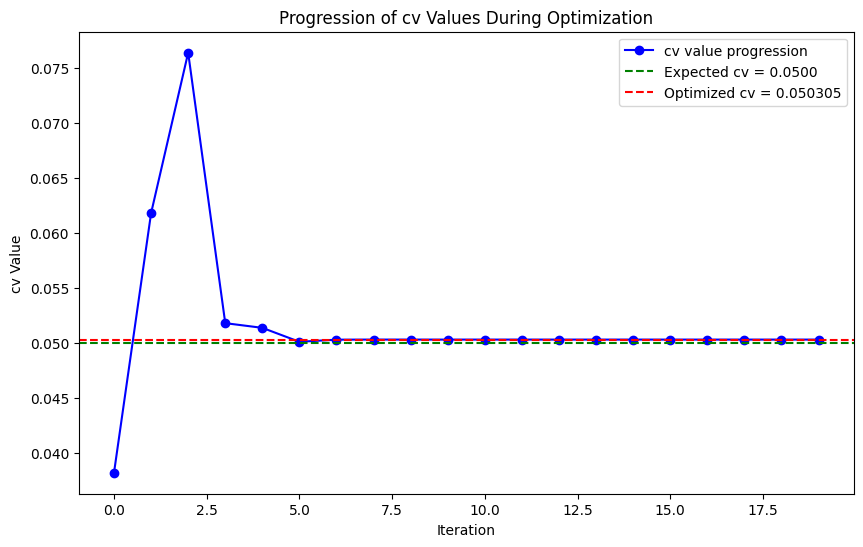

In [25]:
from scipy.optimize import minimize_scalar

cv_test = 0.05
N = 45

u_loaded = np.load(os.path.join(save_directory, f'3D_Simple_{cv_test}_{N}.npy'))
t_index = int(0.3 * (21600-1)) # using t = 0.3 to test.
u_t = u_loaded[:, :, :, t_index]

xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

cv_values_tested = []

def error_function(cv_value):
    # Log the cv value for plotting
    cv_values_tested.append(cv_value)
    
    cv = np.ones_like(Xtest.flatten()) * cv_value
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv]
    pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    return np.mean((pd_eval - u_t)**2)

result = minimize_scalar(error_function, bounds=(0, 0.1), method='bounded', options={'xatol': 1e-20})
best_cv = result.x
min_error = result.fun

print(f"Optimized best cv value: {best_cv}, with minimal error: {min_error}")

# Plot cv values tested over the optimization "time"
plt.figure(figsize=(10, 6))
plt.plot(cv_values_tested, marker='o', linestyle='-', color='b', label='cv value progression')
plt.axhline(y=cv_test, color='g', linestyle='--', label=f'Expected cv = {cv_test:.4f}')
plt.axhline(y=best_cv, color='r', linestyle='--', label=f'Optimized cv = {best_cv:.6f}')

# Add labels and legend
plt.xlabel("Iteration")
plt.ylabel("cv Value")
plt.title("Progression of cv Values During Optimization")
plt.legend()
plt.show()

### Testing the Model

NameError: name 'save_directory' is not defined

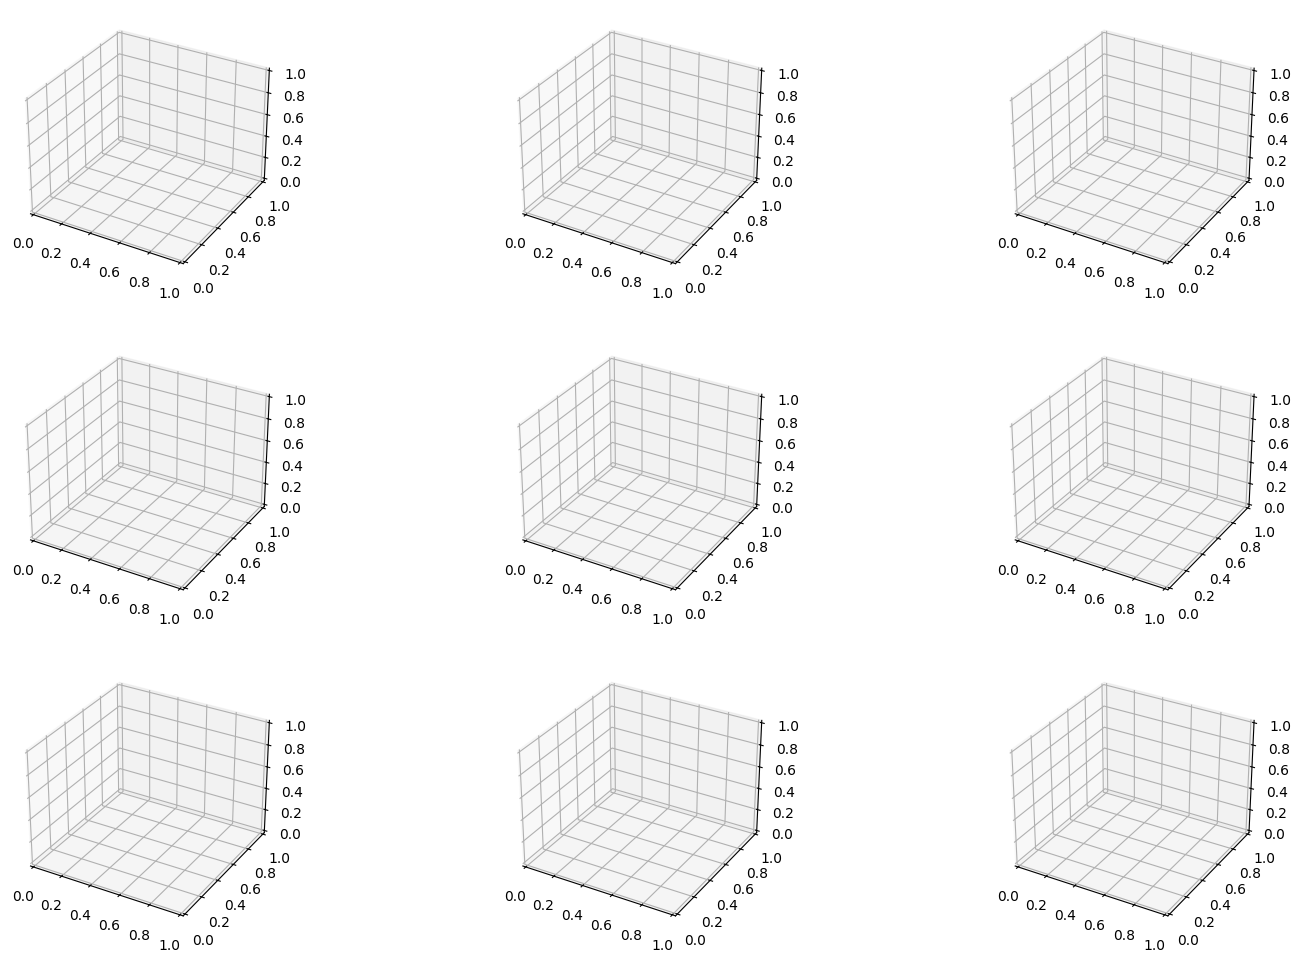

In [10]:
# Define the evaluation grid
xs = np.linspace(0, 1, 60)
ys = np.linspace(0, 1, 60)
zs = np.linspace(0, 1, 60)
ts = np.linspace(0, 1, 21600)

# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(6, 3, figsize=(15, 30), subplot_kw={'projection': '3d'})

for i, cv_value in enumerate([0.085, 0.115, 0.135, 0.165]):
    u_loaded = np.load(os.path.join(save_directory, f'3D_Simple_{cv_value}_60.npy'))
    
    # Meshgrid for 3D evaluation
    Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
    cv = np.ones_like(Xtest.flatten()) * cv_value

    t_index = int(0.5 * (21600-1)) # using t = 0.5 to plot.
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    # Extract the exact pore pressure at the specified time
    u_t = u_loaded[:, :, :, t_index]
    
    # Calculate the difference/errors
    difference = p_pred_fixed_time - u_t
    
    # Flatten data for 3D plotting
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()
    p_flat = p_pred_fixed_time.flatten()
    
    u_flat = u_t.flatten()
    d_flat = difference.flatten()

    # Filter to include only the specified y range
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)

    # Plotting PINN result
    scatter_plot_0 = axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN Solution for cv = {cv_value}')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    fig.colorbar(scatter_plot_0, ax=axs[i, 0], shrink=0.8, pad=0.15)

    # Plotting exact solution
    scatter_plot_1 = axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 1].set_title(f'Exact Solution for cv = {cv_value}')
    axs[i, 1].set_xlabel('X')
    axs[i, 1].set_ylabel('Y')
    axs[i, 1].set_zlabel('Z')
    axs[i, 1].set_xlim([0, 1])
    axs[i, 1].set_ylim([0, 1])
    axs[i, 1].set_zlim([0, 1])
    fig.colorbar(scatter_plot_1, ax=axs[i, 1], shrink=0.8, pad=0.15)
    
    # Plotting difference/errors
    scatter_plot_2 = axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat[mask], cmap='seismic', marker='o', alpha=1.)
    axs[i, 2].set_title(f'Difference for cv = {cv_value}')
    axs[i, 2].set_xlabel('X')
    axs[i, 2].set_ylabel('Y')
    axs[i, 2].set_zlabel('Z')
    axs[i, 2].set_xlim([0, 1])
    axs[i, 2].set_ylim([0, 1])
    axs[i, 2].set_zlim([0, 1])
    fig.colorbar(scatter_plot_2, ax=axs[i, 2], shrink=0.8, pad=0.15)

plt.savefig(f"3D-Contour-Plots_Simple.png", dpi=600)
plt.show()

In [19]:
# # Define the range of cv values to test and initialize minimum error tracking
# cv_values = np.linspace(cv_test/2 cv_test*2, 1000)
# min_error = float('inf')
# best_cv = None

# # Loop through each cv value to find the one with minimal error
# for cv_value in cv_values:
#     cv = np.ones_like(Xtest.flatten()) * cv_value
#     input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv]
#     pd_eval = pd.eval(input_test).reshape(Xtest.shape)

#     # Calculate error (MSE)
#     error = np.mean((pd_eval - u_t)**2)

#     # Update best cv if current error is lower
#     if error < min_error:
#         min_error = error
#         best_cv = cv_value